In [1]:
# Imports
import pandas as pd
import glob
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
from sklearn.linear_model import LinearRegression

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb, RCOT

def save_file(saving_name, matrix):
    print(matrix.shape)
    np.save(saving_name, matrix)

# control group model learning

In [2]:
# read data
control_training_file_names = glob.glob('./new_fmri_data/fmri_data/controls_train/*.csv')
# file_names = glob.glob('./fmri data/fmri data/controls/CMU_b_0050643_rois_dosenbach160.1D.csv')
control_training_data = pd.concat([pd.read_csv(f, delimiter = '\t') for f in control_training_file_names], ignore_index = True)
control_training_data = control_training_data.drop("#223", axis=1)
control_training_data = np.array(control_training_data)
print "control training dataset size:", control_training_data.shape

# read data
control_testing_file_names = glob.glob('./new_fmri_data/fmri_data/controls_test/*.csv')
# file_names = glob.glob('./fmri data/fmri data/controls/CMU_b_0050643_rois_dosenbach160.1D.csv')
control_testing_data = pd.concat([pd.read_csv(f, delimiter = '\t') for f in control_testing_file_names], ignore_index = True)
control_testing_data = control_testing_data.drop("#223", axis=1)
control_testing_data = np.array(control_testing_data)

# Data must be array of shape (time, variables)
t_start = time.time()

control_dataframe = pp.DataFrame(control_training_data)
# independence test methods: ParCorr, CMIknn, RCOT
cond_ind_test = ParCorr()
# cond_ind_test = CMIknn()
# cond_ind_test = RCOT(significance='analytic')
alpha  = 0.01

control_pcmci = PCMCI(dataframe=control_dataframe, cond_ind_test=cond_ind_test)
control_results = control_pcmci.run_pcmci(tau_max=1, pc_alpha=alpha)
# control_pcmci.print_significant_links(p_matrix=control_results['p_matrix'],
#                                      val_matrix=control_results['val_matrix'],
#                                      alpha_level=alpha)

control_link_matrix = control_pcmci.return_significant_parents(pq_matrix=control_results['p_matrix'], \
                                               val_matrix=control_results['val_matrix'], alpha_level=0.01)['link_matrix']

saving_name = './ParCorr_1e-2_control_link_matrix_all.npy'
save_file(saving_name, control_link_matrix)


print np.sum(control_link_matrix[:,:,0]), np.sum(control_link_matrix[:,:,1])
print "running time:", time.time()-t_start

control training dataset size: (1774, 160)
(160, 160, 2)
24558 974
running time: 74.9979679585


# asd group model learning

In [3]:
# read data
asd_training_file_names = glob.glob('./new_fmri_data/fmri_data/asd_train/*.csv')
# file_names = glob.glob('./fmri data/fmri data/controls/CMU_b_0050643_rois_dosenbach160.1D.csv')
asd_training_data = pd.concat([pd.read_csv(f, delimiter = '\t') for f in asd_training_file_names], ignore_index = True)
asd_training_data = asd_training_data.drop("#223", axis=1)
asd_training_data = np.array(asd_training_data)
print "asd training dataset size:", asd_training_data.shape

# read data
asd_testing_file_names = glob.glob('./new_fmri_data/fmri_data/asd_test/*.csv')
# file_names = glob.glob('./fmri data/fmri data/controls/CMU_b_0050643_rois_dosenbach160.1D.csv')
asd_testing_data = pd.concat([pd.read_csv(f, delimiter = '\t') for f in asd_testing_file_names], ignore_index = True)
asd_testing_data = asd_testing_data.drop("#223", axis=1)
asd_testing_data = np.array(asd_testing_data)

# Data must be array of shape (time, variables)
t_start = time.time()

asd_dataframe = pp.DataFrame(asd_training_data)
# independence test methods: ParCorr, CMIknn, RCOT
cond_ind_test = ParCorr()
# cond_ind_test = CMIknn()
# cond_ind_test = RCOT(significance='analytic')
alpha  = 0.01

asd_pcmci = PCMCI(dataframe=asd_dataframe, cond_ind_test=cond_ind_test)
asd_results = asd_pcmci.run_pcmci(tau_max=1, pc_alpha=alpha)
# asd_pcmci.print_significant_links(p_matrix=asd_results['p_matrix'],
#                                      val_matrix=asd_results['val_matrix'],
#                                      alpha_level=alpha)

asd_link_matrix = asd_pcmci.return_significant_parents(pq_matrix=asd_results['p_matrix'], \
                                               val_matrix=asd_results['val_matrix'], alpha_level=0.01)['link_matrix']

saving_name = './ParCorr_1e-2_asd_link_matrix_all.npy'
save_file(saving_name, asd_link_matrix)


print np.sum(asd_link_matrix[:,:,0]), np.sum(asd_link_matrix[:,:,1])
print "running time:", time.time()-t_start

asd training dataset size: (1642, 160)
(160, 160, 2)
24444 461
running time: 62.536698103


# control group var state prediction

parent nodes: 1 [98]

Text(0,0.5,'Predicted test data')

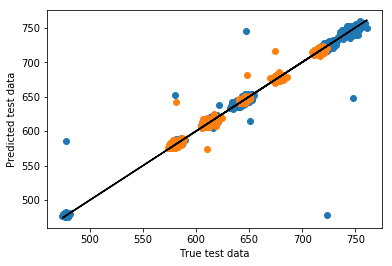

In [4]:
child_node = 98

t_1 = control_link_matrix[:,child_node][:,1]
parent_node = [idx for idx in range(t_1.shape[0]) if t_1[idx]==True]
print "parent nodes:", len(parent_node), parent_node,

X_train = control_training_data[:,parent_node][:-1]
y_train = control_training_data[:,child_node][1:]

reg = LinearRegression().fit(X_train, y_train)

plt.scatter(y_train.reshape(-1), (X_train.dot(reg.coef_.reshape(-1,1))+reg.intercept_))
plt.plot(y_train.reshape(-1), y_train.reshape(-1), 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')


X_test = control_testing_data[:,parent_node][:-1]
y_test = control_testing_data[:,child_node][1:]

plt.scatter(y_test.reshape(-1), (X_test.dot(reg.coef_.reshape(-1,1))+reg.intercept_))
plt.plot(y_test.reshape(-1), y_test.reshape(-1), 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

# asd group var state prediction

parent nodes: [85, 98, 148, 157]


Text(0,0.5,'Predicted test data')

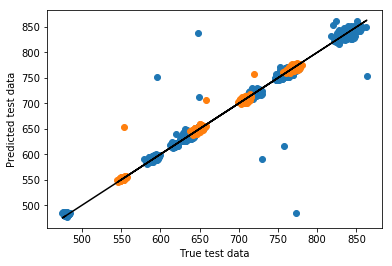

In [5]:
child_node = 98

t_1 = asd_link_matrix[:,child_node][:,1]
parent_node = [idx for idx in range(t_1.shape[0]) if t_1[idx]==True]
print "parent nodes:", parent_node

X_train = asd_training_data[:,parent_node][:-1]
y_train = asd_training_data[:,child_node][1:]

reg = LinearRegression().fit(X_train, y_train)

plt.scatter(y_train.reshape(-1), (X_train.dot(reg.coef_.reshape(-1,1))+reg.intercept_))
plt.plot(y_train.reshape(-1), y_train.reshape(-1), 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')


X_test = asd_testing_data[:,parent_node][:-1]
y_test = asd_testing_data[:,child_node][1:]

plt.scatter(y_test.reshape(-1), (X_test.dot(reg.coef_.reshape(-1,1))+reg.intercept_))
plt.plot(y_test.reshape(-1), y_test.reshape(-1), 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

# predict whether the person is asd?

In [6]:
# predict diagnosis statistics: the number of different connections

def matrix_comparison(m, control_matrix, asd_matrix, person_code=1):   
    print "************************************************"
    print "Statistics:"
    # inter-slice comparison
    control_num_diff_links = np.sum(m[:,:,1]!=control_matrix[:,:,1])
    asd_num_diff_links = np.sum(m[:,:,1]!=asd_matrix[:,:,1])
    print "interslice different links------ control group:", control_num_diff_links, \
                                            "     asd group", asd_num_diff_links
    # intra-slice comparison
    control_num_diff_links = np.sum(m[:,:,0]!=control_matrix[:,:,0])
    asd_num_diff_links = np.sum(m[:,:,0]!=asd_matrix[:,:,0])
    print "intraslice different links------ control group:", control_num_diff_links, \
                                            "     asd group", asd_num_diff_links
    
    # overall comparison
    control_num_diff_links = np.sum(m!=control_matrix)
    asd_num_diff_links = np.sum(m!=asd_matrix)
    print "total number of different links------ control group:", control_num_diff_links, \
                                            "     asd group", asd_num_diff_links
        
    print "************************************************"
    if control_num_diff_links<asd_num_diff_links:
        print "person name:", person_code, "IF ASD? NO"
    else:
        print "person name:", person_code, "         IF ASD? YES"
        
    print "************************************************"
    print " "

# matrix_comparison(person_link_matrix, control_link_matrix, asd_link_matrix, "lucky")


In [7]:
# for each one in the control_test group, predict whether the person is with asd?
# read data
control_testing_file_names = glob.glob('./new_fmri_data/fmri_data/controls_test/*.csv')

for f in control_testing_file_names:
    person_data = pd.read_csv(f, delimiter = '\t')
    person_data = person_data.drop("#223", axis=1)
    person_data = np.array(person_data)
    print "personal data format", person_data.shape


    # Data must be array of shape (time, variables)
    t_start = time.time()

    person_dataframe = pp.DataFrame(person_data)
    # independence test methods: ParCorr, CMIknn, RCOT
    cond_ind_test = ParCorr()
    # cond_ind_test = CMIknn()
#     cond_ind_test = RCOT(significance='analytic')
    alpha  = 0.01

    person_pcmci = PCMCI(dataframe=person_dataframe, cond_ind_test=cond_ind_test)
    person_results = person_pcmci.run_pcmci(tau_max=1, pc_alpha=alpha)
    # person_pcmci.print_significant_links(p_matrix=person_results['p_matrix'],
    #                                      val_matrix=person_results['val_matrix'],
    #                                      alpha_level=alpha)
    person_link_matrix = person_pcmci.return_significant_parents(pq_matrix=person_results['p_matrix'], \
                                                   val_matrix=person_results['val_matrix'], alpha_level=0.01)['link_matrix']

    print "running time:", time.time()-t_start
    print np.sum(person_link_matrix[:,:,0]), np.sum(person_link_matrix[:,:,1])
    matrix_comparison(person_link_matrix, control_link_matrix, asd_link_matrix, f)

personal data format (320, 160)
running time: 47.5581009388
11432 1333
************************************************
Statistics:
interslice different links------ control group: 2095      asd group 1624
intraslice different links------ control group: 13710      asd group 13528
total number of different links------ control group: 15805      asd group 15152
************************************************
person name: ./new_fmri_data/fmri_data/controls_test/CMU_b_0050669_rois_dosenbach160.1D.csv          IF ASD? YES
************************************************
 
personal data format (244, 160)
running time: 49.0551362038
6688 974
************************************************
Statistics:
interslice different links------ control group: 1740      asd group 1273
intraslice different links------ control group: 18226      asd group 18124
total number of different links------ control group: 19966      asd group 19397
************************************************
person name: ./new_f

In [8]:
# for each one in the asd_test group, predict whether the person is with asd?
# read data
asd_testing_file_names = glob.glob('./new_fmri_data/fmri_data/asd_test/*.csv')

for f in asd_testing_file_names:
    person_data = pd.read_csv(f, delimiter = '\t')
    person_data = person_data.drop("#223", axis=1)
    person_data = np.array(person_data)
    print "personal data format", person_data.shape


    # Data must be array of shape (time, variables)
    t_start = time.time()

    person_dataframe = pp.DataFrame(person_data)
    # independence test methods: ParCorr, CMIknn, RCOT
    cond_ind_test = ParCorr()
    # cond_ind_test = CMIknn()
#     cond_ind_test = RCOT(significance='analytic')
    alpha  = 0.01

    person_pcmci = PCMCI(dataframe=person_dataframe, cond_ind_test=cond_ind_test)
    person_results = person_pcmci.run_pcmci(tau_max=1, pc_alpha=alpha)
    # person_pcmci.print_significant_links(p_matrix=person_results['p_matrix'],
    #                                      val_matrix=person_results['val_matrix'],
    #                                      alpha_level=alpha)
    person_link_matrix = person_pcmci.return_significant_parents(pq_matrix=person_results['p_matrix'], \
                                                   val_matrix=person_results['val_matrix'], alpha_level=0.01)['link_matrix']

    print "running time:", time.time()-t_start
    print np.sum(person_link_matrix[:,:,0]), np.sum(person_link_matrix[:,:,1])
    matrix_comparison(person_link_matrix, control_link_matrix, asd_link_matrix, f)

personal data format (225, 160)
running time: 47.5301179886
8664 1090
************************************************
Statistics:
interslice different links------ control group: 1836      asd group 1351
intraslice different links------ control group: 16554      asd group 16132
total number of different links------ control group: 18390      asd group 17483
************************************************
person name: ./new_fmri_data/fmri_data/asd_test/CMU_a_0050653_rois_dosenbach160.1D.csv          IF ASD? YES
************************************************
 
personal data format (225, 160)
running time: 43.6976380348
5688 1077
************************************************
Statistics:
interslice different links------ control group: 1869      asd group 1408
intraslice different links------ control group: 19142      asd group 19096
total number of different links------ control group: 21011      asd group 20504
************************************************
person name: ./new_fmri_d